# Notes: 

    - Some product names go by 10's of ID's, should we drop name or ID? We would have more unique values with ID 
      but it would be more redundant, whereas we could have only ~ 4000 unique names to work with 
            - The product ID seems to correspond to the category and subcategory, for example: 
             
                              TEC-AC-10003033	Technology	Accessories
               
    - There are exactly 2 Customer ID's for each Customer, and they look very similar except one is less a digit, 
      like the following: Michael Chen	['MC-17845' 'MC-7845']. 
            - Does it make sense then to get rid of the Customer ID's and just Use the names? Or to assign 
              one customer ID to each customer rather than 2? 
   - Order ID: 
       There are 51290 rows, but 25035 order ID values, so what does Order ID really represent if not each order?
       
   - Calculate profits per year/ per month 
   
   - How much profit per product? per Customer? per Area? Etc?
   
   - Fix skewed predictors?

## Setup 

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

import matplotlib.pylab as plt
%matplotlib inline

import statsmodels.formula.api as sm
from scipy.stats import skew

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge, SGDRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix,r2_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler


import statsmodels.tools.tools as stattools

## Load Data

In [119]:
# import the original df and then make a copy for preprocessing so we have the original if needed 
og_df  = pd.read_csv(r'/Users/summerpurschke/Desktop/ADS/Global_Superstore2.csv')

df = og_df.copy()

In [120]:
df.dtypes

Row ID              int64
Order ID           object
Order Date         object
Ship Date          object
Ship Mode          object
Customer ID        object
Customer Name      object
Segment            object
City               object
State              object
Country            object
Postal Code       float64
Market             object
Region             object
Product ID         object
Category           object
Sub-Category       object
Product Name       object
Sales             float64
Quantity            int64
Discount          float64
Profit            float64
Shipping Cost     float64
Order Priority     object
dtype: object

## Explore Data 

In [121]:
#df.info()

In [122]:
#df.describe()

In [123]:
# Skewed predictors
print('Sales Skew:', skew(df['Sales'], axis = 0, bias = True ))
print('Quantity Skew:', skew(df['Quantity'], axis = 0, bias = True ))
print('Discount Skew:', skew(df['Discount'], axis = 0, bias = True ))
print('Profit Skew:', skew(df['Profit'], axis = 0, bias = True ))
print('Shipping Cost Skew:', skew(df['Shipping Cost'], axis = 0, bias = True ))

Sales Skew: 8.137842017336732
Quantity Skew: 1.3603279457897046
Discount Skew: 1.3877339656893208
Profit Skew: 4.157066952869827
Shipping Cost Skew: 5.863054951522988


In [124]:
# Format column names 
df.columns = [d.replace(' ', '_') for d in df.columns]
df.columns = [d.replace('-', '_') for d in df.columns]

In [125]:
# Missing values 
df.isnull().sum(axis = 0)

Row_ID                0
Order_ID              0
Order_Date            0
Ship_Date             0
Ship_Mode             0
Customer_ID           0
Customer_Name         0
Segment               0
City                  0
State                 0
Country               0
Postal_Code       41296
Market                0
Region                0
Product_ID            0
Category              0
Sub_Category          0
Product_Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping_Cost         0
Order_Priority        0
dtype: int64

In [126]:
# Change time/date variables to correct format 
df['Order_Date'] = pd.to_datetime(df['Order_Date'], infer_datetime_format=True)
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], infer_datetime_format=True)

In [127]:
df.dtypes

Row_ID                     int64
Order_ID                  object
Order_Date        datetime64[ns]
Ship_Date         datetime64[ns]
Ship_Mode                 object
Customer_ID               object
Customer_Name             object
Segment                   object
City                      object
State                     object
Country                   object
Postal_Code              float64
Market                    object
Region                    object
Product_ID                object
Category                  object
Sub_Category              object
Product_Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
Shipping_Cost            float64
Order_Priority            object
dtype: object

In [128]:
# Coerce categories as needed for analysis 
df['Ship_Mode']= df['Ship_Mode'].astype('category')
df['Segment']= df['Segment'].astype('category')
df['Country']= df['Country'].astype('category')
df['Market']= df['Market'].astype('category')
df['Region']= df['Region'].astype('category')
df['Category']= df['Category'].astype('category')
df['Sub_Category']= df['Sub_Category'].astype('category')
df['Order_Priority']= df['Order_Priority'].astype('category')

In [129]:
df['Order_ID'].nunique(), df.shape

(25035, (51290, 24))

In [130]:
# How many Order ID's per country? 
print(' Quantity of Order IDs per country)
df.groupby(['Country']).count()[['Order_ID']]  

SyntaxError: EOL while scanning string literal (<ipython-input-130-6246587286fd>, line 2)

In [ ]:
# How many Order ID's per city? 
df.groupby(['City']).count()[['Order_ID']]

In [ ]:
# Which city purchases the highest quantity of products?  
biggest_procurement = df.groupby(['Country']).sum()[['Quantity']].nlargest(n=10, columns=['Quantity'])
biggest_procurement

In [ ]:
# Which product is the most profitable? 
most_profitable_product = df.groupby(['Product_Name']).sum()[['Profit']].nlargest(n=5, columns=['Profit'])
most_profitable_product

In [ ]:
# Which country is the most profitable? 
most_profitable_country = df.groupby(['Country']).sum()[['Profit']].nlargest(n=5, columns=['Profit'])
most_profitable_country

In [ ]:
# How many product ID's are there? How many Product Names?
print('There are', df_copy['Product ID'].nunique(), 'unique product IDs, and', 
      df_copy['Product Name'].nunique(), ' unique product names')


# There are only 3788 Unique products, but some go by different ID's

group = pd.DataFrame(df_copy.groupby('Product Name')['Product ID'].unique())
group['Product ID'] = group['Product ID'].astype('str')
group['#Product IDs'] = group['Product ID'].str.split(' ').apply(len)

products  = group.sort_values(by = ['#Product IDs'], ascending = False)
products.head()

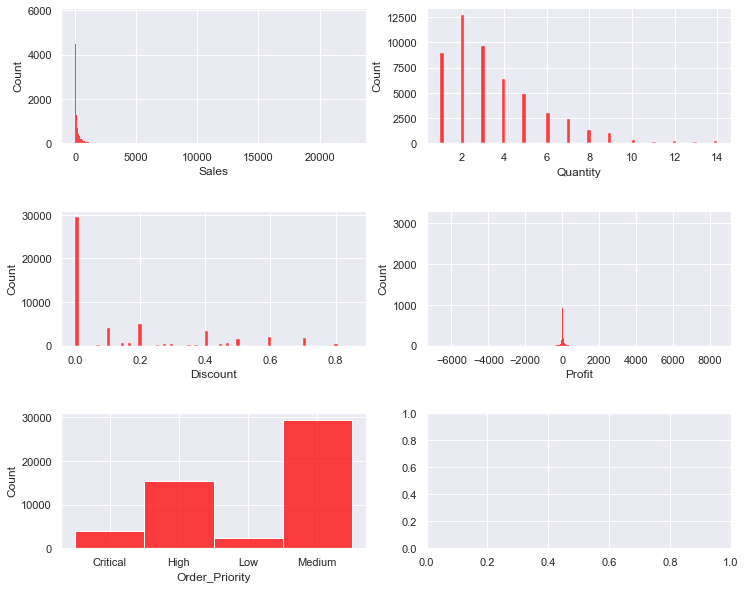

In [131]:
# Plot numeric histograms here

sns.set(font_scale=1)
fig, axs = plt.subplots(3, 2, figsize = (12,12))
fig.subplots_adjust(hspace=0.5, top = 0.75)

sns.histplot(df['Sales'], color="red", ax=axs[0, 0])
sns.histplot(df['Quantity'], color="red", ax=axs[0, 1])
sns.histplot(df['Discount'], color="red", ax=axs[1, 0])
sns.histplot(df['Profit'], color="red", ax=axs[1, 1])
sns.histplot(df['Order_Priority'], color="red", ax=axs[2, 0])

plt.show()

In [22]:
# Make sure that there is one unqiue row ID for each row in the df before reindexing using Row ID 
print('There are',df['Row_ID'].nunique(),'Row ID values, and', df.shape, 'Rows x Columns')

There are 51290 Row ID values, and (51290, 24) Rows x Columns


In [25]:
# How many customer ID's are there? How many customer Names?
print('There are', df_copy['Customer ID'].nunique(), 'unique Customer IDs, and', 
      df_copy['Customer Name'].nunique(), ' unique Customer names')

# There are only 795 Unique customers, each having 2 customer ID's that look similar 

group1 = pd.DataFrame(df_copy.groupby('Customer Name')['Customer ID'].unique())
group1['Customer ID'] = group1['Customer ID'].astype('str')
group1['#Customer IDs'] = group1['Customer ID'].str.split(' ').apply(len)

customers  = group1.sort_values(by = ['#Customer IDs'], ascending = False)
customers.tail()

# It seems that there are two Customer ID's for each Name - Redundant 

There are 1590 unique Customer IDs, and 795  unique Customer names


,Customer ID,#Customer IDs
Customer Name,,
Erica Smith,['ES-14020' 'ES-4020'],2
Erin Ashbrook,['EA-14035' 'EA-4035'],2
Erin Creighton,['EC-14050' 'EC-4050'],2
Erin Mull,['EM-14065' 'EM-4065'],2
Zuschuss Donatelli,['ZD-21925' 'ZD-11925'],2


## Preprocessing

In [132]:
df.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'City', 'State', 'Country',
       'Postal_Code', 'Market', 'Region', 'Product_ID', 'Category',
       'Sub_Category', 'Product_Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping_Cost', 'Order_Priority'],
      dtype='object')

In [161]:
# Feature Selection, comment out features to drop 
numeric = df[[
    'Sales', 
    'Quantity', 
    'Discount',
    'Profit', 
    'Shipping_Cost'
]]

ordinal = pd.DataFrame(df['Order_Priority'])

categorical = df[[
#    'Row_ID', 
#    'Order_ID', 
#    'Order_Date', 
#    'Ship_Date', 
#    'Ship_Mode',
#    'Customer_ID', 
#    'Customer_Name', 
    'Segment', 
    'City', 
    'State', 
    'Country',
#    'Postal_Code', 
    'Market', 
    'Region', 
#    'Product_ID', 
    'Category',
    'Sub_Category', 
    'Product_Name'
]]

In [141]:
# Ordinal Encoding 
dict = {'Critical': 4, 'Medium' : 3, 'High' : 2, 'Low': 1}
ordinal = ordinal.replace({'Order_Priority': dict})
ordinal.head()

,Order_Priority
0,4
1,4
2,3
3,3
4,4


In [53]:
df.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Segment', 'City', 'State', 'Country', 'Market',
       'Region', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping_Cost',
       'Order_Priority'],
      dtype='object')

In [151]:
# create binary variable that = 1 if positive profit and = 0 if negative profit 
profitable = pd.DataFrame(np.where(df['Profit'] > 0, 1, 0), columns = ['Profitable'])
profitable.head()

,Profitable
0,1
1,0
2,1
3,0
4,1


In [163]:
# categorical variables - dummy encode
s1 = pd.get_dummies(categorical)

#numerical variables - normalize 
s2 = pd.DataFrame(MinMaxScaler().fit_transform(numeric), columns = numeric.columns)

# add target variables (no preprocessing)
s3 = profitable 

In [168]:
# something is wrong with concat where I'm getting NA values, I think it has to do with the index 
df = (pd.concat([s1,s2, s3], axis = 1)).dropna()
df.head()

,Segment_Consumer,Segment_Corporate,Segment_Home Office,City_Aachen,City_Aalen,City_Aalst,City_Aba,City_Abadan,City_Abakaliki,City_Abbeville,...,Product_Name_iOttie HLCRIO102 Car Mount,Product_Name_iOttie XL Car Mount,Product_Name_invisibleSHIELD by ZAGG Smudge-Free Screen Protector,Product_Name_netTALK DUO VoIP Telephone Service,Sales,Quantity,Discount,Profit,Shipping_Cost,Profitable
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.102006,0.461538,0.000000,0.490812,1.000000,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.163837,0.615385,0.117647,0.420749,0.989353,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.228586,0.615385,0.117647,0.501331,0.980633,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0.127753,0.307692,0.117647,0.433564,0.974924,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.125122,0.538462,0.000000,0.460768,0.967298,1


In [169]:
# Split into X/ Y 
X = df.drop(columns=['Profitable','Profit'])
y = df['Profitable']   # classification target

#Split into Train/Test - Regression 
X_train, X_valid, y_train, y_valid= train_test_split(X, y, test_size=0.2, random_state=47)

In [170]:
# Logistic Regression -  Classification 
logr = LogisticRegression(penalty = 'l2', C = 1e12, solver = 'liblinear').fit(X_train, y_train)

# obtaining accuracy scores for logistic regression model 
print(f'training model score:{logr.score(X_train, y_train)}')
print(f'test model score:{logr.score(X_valid, y_valid)}')
#print('R2 Value:', r2_score(y_valid, logr.predict(X_train)))

training model score:0.9707789042698381
test model score:0.9209397543380776


In [171]:
# reassign y to classification target variable 
y = df_profit['Profit']

In [172]:
# Linear Regression -  Regression
lr = LinearRegression().fit(X_train, y_train)

# obtaining accuracy scores for logistic regression model 
print(f'training model score:{lr.score(X_train, y_train)}')
print(f'test model score:{lr.score(X_valid, y_valid)}')
#print('R2 Value:', r2_score(y_valid, lr.predict(X_train)))

training model score:0.7670143577053401
test model score:-1.1751701625077276e+23


In [173]:
# Support Vector Machine -  Regression
svm = SVR(C = 2, kernel = 'linear', max_iter = 1000).fit(X_train, y_train)

# obtaining accuracy scores for logistic regression model 
print(f'training model score:{svm.score(X_train, y_train)}')
print(f'test model score:{svm.score(X_valid, y_valid)}')
#print('R2 Value:',metrics.r2_score(y_valid, SVM.predict(X_train)))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


training model score:0.18353450932664783
test model score:0.1848739846878681
